In [1]:
! pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download jessicali9530/celeba-dataset

100% 1.33G/1.33G [00:33<00:00, 50.2MB/s]
100% 1.33G/1.33G [00:33<00:00, 42.7MB/s]


In [6]:
! unzip -d dataset celeba-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: dataset/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: dataset/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: dataset/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: dataset/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: dataset/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: dataset/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: dataset/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: dataset/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: dataset/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: dataset/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: dataset/img_align_celeba/img_align_celeba/197616.jpg  
  inflating: dataset/img_align_celeba/img_align_celeba/197617.jpg  
  inflating: dataset/img_align_celeba/img_align_celeba/197618.jpg

In [7]:
import pandas as pd
import numpy as np

attributes = pd.read_csv('./dataset/list_attr_celeba.csv')

In [9]:
train_size = 182016
train = attributes.iloc[:train_size, :]
test = attributes.iloc[train_size:, :]
train = train.replace(-1, 0)
test = test.replace(-1, 0)
y_cols = list(train.iloc[:1, 1:].columns)

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Flatten, LeakyReLU, Dropout
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD

cnn_input = Input((218, 178, 3))

cnn = Conv2D(filters=64, strides=(2, 2), kernel_size=(3, 3), padding='same', kernel_initializer='he_uniform')(cnn_input)
cnn = LeakyReLU()(cnn)
cnn = BatchNormalization()(cnn)
cnn = Conv2D(filters=64, strides=(2, 2), kernel_size=(3, 3), padding='same', kernel_initializer='he_uniform')(cnn)
cnn = LeakyReLU()(cnn)
cnn = BatchNormalization()(cnn)
cnn = MaxPool2D((2, 2), padding='same')(cnn)

cnn = Conv2D(filters=128, strides=(2, 2), kernel_size=(3, 3), padding='same', kernel_initializer='he_uniform')(cnn)
cnn = LeakyReLU()(cnn)
cnn = BatchNormalization()(cnn)
cnn = Conv2D(filters=128, strides=(2, 2), kernel_size=(3, 3), padding='same', kernel_initializer='he_uniform')(cnn)
cnn = LeakyReLU()(cnn)
cnn = BatchNormalization()(cnn)
cnn = MaxPool2D((2, 2), padding='same')(cnn)

cnn = Conv2D(filters=256, strides=(2, 2), kernel_size=(3, 3), padding='same', kernel_initializer='he_uniform')(cnn)
cnn = LeakyReLU()(cnn)
cnn = BatchNormalization()(cnn)
cnn = Conv2D(filters=256, strides=(2, 2), kernel_size=(3, 3), padding='same', kernel_initializer='he_uniform')(cnn)
cnn = LeakyReLU()(cnn)
cnn = BatchNormalization()(cnn)
cnn = MaxPool2D((2, 2), padding='same')(cnn)

cnn = Flatten()(cnn)
cnn = Dense(1024, kernel_initializer='he_uniform')(cnn)
cnn = LeakyReLU()(cnn)
cnn = BatchNormalization()(cnn)
cnn = Dropout(0.6)(cnn)
cnn = Dense(256, kernel_initializer='he_uniform')(cnn)
cnn = LeakyReLU()(cnn)
cnn = BatchNormalization()(cnn)
cnn = Dropout(0.6)(cnn)

cnn_output = Dense(40, activation='sigmoid')(cnn)

model = Model(cnn_input, cnn_output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC(), Precision(), Recall()])

my_callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
                ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e6, verbose=1)]

In [ ]:
def make_batch_images(images, path='./dataset/img_align_celeba/img_align_celeba', batch_size=64):
    X = []
    for i, image in enumerate(images):
        img = load_img(f'{path}/{image}')
        X.append(img_to_array(img))
    return np.array(X)/255


def make_test_samples(test_images, test_labels, size=10000):
    indices = np.random.choice(test_size, size, replace=False)
    y = test_labels.iloc[indices, :].values
    X = make_batch_images(test_images.iloc[indices])
    return X, y

In [45]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
path = './dataset/img_align_celeba/img_align_celeba'

train_datagen = ImageDataGenerator(rescale = 1./255)

train_set = train_datagen.flow_from_dataframe(dataframe=train, directory=path,
                                              x_col='image_id', y_col=y_cols, target_size=(218, 178),
                                              class_mode='raw')

test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_dataframe(dataframe=test, directory=path,
                                            x_col='image_id', y_col=y_cols, target_size=(218, 178),
                                            class_mode='raw', shuffle=False)

Found 182016 validated image filenames.
Found 20583 validated image filenames.


In [ ]:
history = model.fit(x=train_set, batch_size=64, epochs=50, validation_data=test_set, callbacks=my_callbacks)

Epoch 1/50
5688/5688 [==============================] - 521s 86ms/step - loss: 0.2951 - auc: 0.9131 - precision: 0.7609 - recall: 0.6223 - val_loss: 0.2450 - val_auc: 0.9427 - val_precision: 0.8173 - val_recall: 0.6774 - lr: 0.0010
Epoch 2/50
5688/5688 [==============================] - 449s 79ms/step - loss: 0.2470 - auc: 0.9400 - precision: 0.8211 - recall: 0.6703 - val_loss: 0.2355 - val_auc: 0.9475 - val_precision: 0.8422 - val_recall: 0.6732 - lr: 0.0010
Epoch 3/50
5688/5688 [==============================] - 448s 79ms/step - loss: 0.2363 - auc: 0.9455 - precision: 0.8278 - recall: 0.6879 - val_loss: 0.2249 - val_auc: 0.9531 - val_precision: 0.8700 - val_recall: 0.6616 - lr: 0.0010
Epoch 4/50
5688/5688 [==============================] - 445s 78ms/step - loss: 0.2296 - auc: 0.9489 - precision: 0.8333 - recall: 0.6984 - val_loss: 0.2178 - val_auc: 0.9565 - val_precision: 0.8779 - val_recall: 0.6735 - lr: 0.0010
Epoch 5/50
5688/5688 [==============================] - 441s 78ms/step -

In [ ]:
model.save('model.h5')

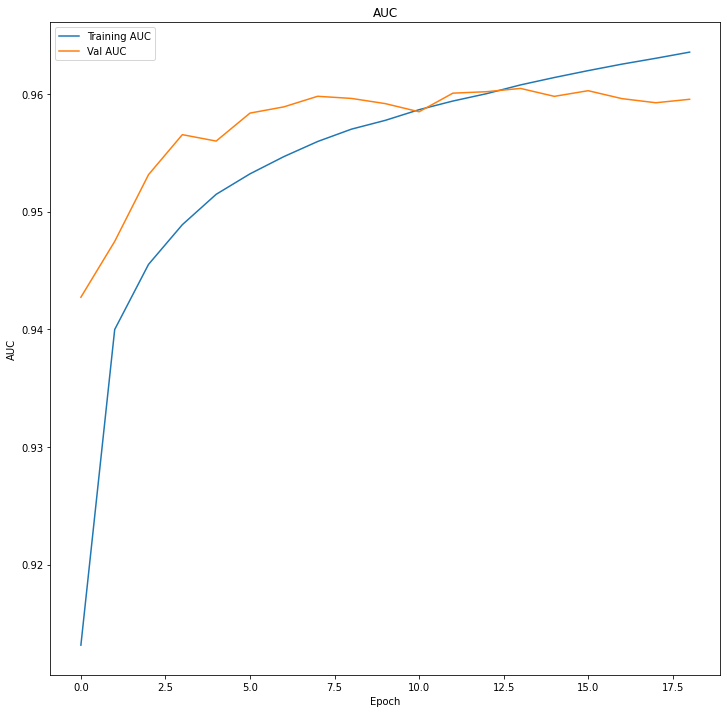

In [ ]:
import matplotlib.pyplot as plt

def plot_history_1(history):
    """
    This function plots the loss value during the training
    """
    plt.figure(figsize=(12, 12))
    plt.subplot(2, 1, 1)
    plt.plot(history.history['loss'])
    plt.title('Training loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(2, 1, 2)
    plt.plot(history.history['val_loss'])
    plt.title('Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.show()


def plot_history(history):
    """
    This function plots the loss value during the training
    """
    plt.figure(figsize=(12, 12))
    plt.plot(history.history['auc'])
    plt.plot(history.history['val_auc'])
    plt.title('AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend(['Training AUC', 'Val AUC'])

    plt.show()

plot_history(history)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 218, 178, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 109, 89, 64)       1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 109, 89, 64)       0         
                                                                 
 batch_normalization (BatchN  (None, 109, 89, 64)      256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 55, 45, 64)        36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 55, 45, 64)        0         
                                                             

In [12]:
from tensorflow.keras.models import load_model

loaded_model = load_model('model.h5')

In [35]:
y_true = test.iloc[:, 1:].values

In [46]:
y_pred = loaded_model.predict(test_set)

In [47]:
y_pred_rounded = np.around(y_pred)

In [59]:
from sklearn.metrics import classification_report, accuracy_score

print(classification_report(y_true, y_pred_rounded, target_names=y_cols))

                     precision    recall  f1-score   support

   5_o_Clock_Shadow       0.76      0.61      0.68      2065
    Arched_Eyebrows       0.73      0.64      0.68      5845
         Attractive       0.80      0.86      0.83     10232
    Bags_Under_Eyes       0.70      0.42      0.53      4164
               Bald       0.69      0.68      0.68       432
              Bangs       0.86      0.87      0.86      3209
           Big_Lips       0.71      0.21      0.32      6625
           Big_Nose       0.65      0.52      0.58      4376
         Black_Hair       0.83      0.75      0.79      5538
         Blond_Hair       0.86      0.80      0.83      2763
             Blurry       0.72      0.38      0.50      1042
         Brown_Hair       0.65      0.72      0.68      3746
     Bushy_Eyebrows       0.81      0.54      0.65      2669
             Chubby       0.65      0.32      0.43      1095
        Double_Chin       0.74      0.29      0.41       943
         Eyeglasses    